In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import numpy as np 
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import random 
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from collections import Counter
from torchtext.vocab import vocab
from torchtext.data.utils import get_tokenizer

In [2]:
def set_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
set_seeds(2562)

## 讀檔

In [3]:
df = pd.read_csv('sentimentData/IMDB Dataset.csv')
reviews = df['review'].values
sentiments = df['sentiment'].values

In [4]:
print('原始標籤:\n', sentiments, end = '\n\n')
print('轉換後的標籤:\n', (sentiments=='positive').astype('float32'))

原始標籤:
 ['positive' 'positive' 'positive' ... 'negative' 'negative' 'negative']

轉換後的標籤:
 [1. 1. 1. ... 0. 0. 0.]


In [5]:
tokenizer = get_tokenizer('basic_english')

print('原始文字:\n', reviews[0], end = '\n\n')
print('轉換後的文字:\n', " ".join(tokenizer(reviews[0])))

原始文字:
 One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to 

In [6]:
counter = Counter()
for review in reviews:
    token = tokenizer(review)
    counter.update(token)

token_vocab = vocab(counter, min_freq=10, specials=('<pad>', '<unk>'))
token_vocab.set_default_index(token_vocab.get_stoi()['<unk>'])

PAD_IDX = token_vocab.get_stoi()['<pad>']
INPUT_DIM = len(token_vocab)

reviews_ids = [torch.tensor(token_vocab.lookup_indices(tokenizer(i))) for i in reviews]
labels = (sentiments=='positive').astype('float32')

x_train, x_valid, y_train, y_valid = train_test_split(reviews_ids, labels, train_size=0.8, random_state=46, shuffle=False)

## 創建資料集

In [7]:
class IMDB(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = IMDB(x_train, y_train)
validset = IMDB(x_valid, y_valid)

In [8]:
def collate_fn(batch):    
    (x, y) = zip(*batch)
    return pad_sequence(x, padding_value=PAD_IDX, batch_first=True), torch.tensor(y)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True, collate_fn=collate_fn)

In [9]:
class TimeSeriesModel(nn.Module):
    def __init__(self, embedding_dim, hidden_size, num_layers=1, bidirectional=True, model_type = 'LSTM'):
        super().__init__()
        self.embedding = nn.Embedding(INPUT_DIM,  embedding_dim, padding_idx = PAD_IDX)
        if model_type == 'LSTM':
            self.series_model =nn.LSTM(embedding_dim, 
                               hidden_size = hidden_size, 
                               num_layers = num_layers,
                               bidirectional = bidirectional,
                               batch_first=True
            )
        elif model_type =='GRU':
            self.series_model =nn.GRU(embedding_dim, 
                               hidden_size = hidden_size, 
                               num_layers = num_layers,
                               bidirectional = bidirectional,
                               batch_first=True
            )
            
        else:
             self.series_model =nn.RNN(embedding_dim, 
                               hidden_size = hidden_size, 
                               num_layers = num_layers,
                               bidirectional = bidirectional,
                               batch_first=True
            )
            

        hidden = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(hidden, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        emb_out = self.embedding(x)
        out, (h, c)  = self.series_model(emb_out)
        x = out[:, -1, :]
        x = self.fc(x)
        
        return self.sigmoid(x)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TimeSeriesModel(embedding_dim = 300, hidden_size= 128, model_type = 'GRU').to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        features, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        optimizer.zero_grad()  # 梯度清零
        outputs = model(features).view(-1) # 模型計算答案(前向傳播)
        
        loss = criterion(outputs, labels) # 計算Loss值
        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失
        
        pred = outputs > 0.5
        train_acc += sum(pred == labels) # 計算預測成功的數量
        train_loss += loss.item()  # 模型總損失
    return train_loss/len(train_loader), train_acc/len(trainset) # 計算一次訓練的Loss與準確率


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            features, labels = [i.to(device) for i in input_datas]
            outputs = model(features).view(-1)
            loss = criterion(outputs, labels)
            
            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            pred = outputs > 0.5
            valid_acc += sum(pred == labels)
            valid_loss += loss.item()

    return valid_loss/len(valid_loader), valid_acc/len(validset)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

Valid Epoch 0: 100%|█████████████████████████████████████████████████████| 157/157 [00:03<00:00, 39.41it/s, loss=0.717]


Saving Model With Acc 0.50090
Train Loss: 0.69346 Train Acc: 0.49935| Valid Loss: 0.69273 Valid Acc: 0.50090| Best Acc: 0.50090



Valid Epoch 1: 100%|█████████████████████████████████████████████████████| 157/157 [00:04<00:00, 37.41it/s, loss=0.699]


Train Loss: 0.69162 Train Acc: 0.50102| Valid Loss: 0.69293 Valid Acc: 0.50090| Best Acc: 0.50090



Valid Epoch 2: 100%|█████████████████████████████████████████████████████| 157/157 [00:05<00:00, 29.12it/s, loss=0.687]


Train Loss: 0.68981 Train Acc: 0.50407| Valid Loss: 0.69342 Valid Acc: 0.50040| Best Acc: 0.50090



Valid Epoch 3: 100%|█████████████████████████████████████████████████████| 157/157 [00:05<00:00, 27.51it/s, loss=0.646]


Saving Model With Acc 0.50140
Train Loss: 0.68765 Train Acc: 0.50980| Valid Loss: 0.69545 Valid Acc: 0.50140| Best Acc: 0.50140



Valid Epoch 4: 100%|█████████████████████████████████████████████████████| 157/157 [00:05<00:00, 28.26it/s, loss=0.655]


Train Loss: 0.68689 Train Acc: 0.50252| Valid Loss: 0.69370 Valid Acc: 0.50120| Best Acc: 0.50140



Valid Epoch 5: 100%|█████████████████████████████████████████████████████| 157/157 [00:07<00:00, 22.08it/s, loss=0.622]


Saving Model With Acc 0.65840
Train Loss: 0.67527 Train Acc: 0.54412| Valid Loss: 0.63498 Valid Acc: 0.65840| Best Acc: 0.65840



Valid Epoch 6: 100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.87it/s, loss=0.434]


Saving Model With Acc 0.75460
Train Loss: 0.56378 Train Acc: 0.71625| Valid Loss: 0.50437 Valid Acc: 0.75460| Best Acc: 0.75460



Valid Epoch 7: 100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 18.13it/s, loss=0.538]


Saving Model With Acc 0.84260
Train Loss: 0.39428 Train Acc: 0.82897| Valid Loss: 0.37500 Valid Acc: 0.84260| Best Acc: 0.84260



Valid Epoch 8: 100%|█████████████████████████████████████████████████████| 157/157 [00:08<00:00, 19.16it/s, loss=0.793]


Saving Model With Acc 0.86420
Train Loss: 0.25750 Train Acc: 0.89922| Valid Loss: 0.33761 Valid Acc: 0.86420| Best Acc: 0.86420



Valid Epoch 9: 100%|█████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.74it/s, loss=0.741]


Saving Model With Acc 0.86520
Train Loss: 0.16135 Train Acc: 0.94320| Valid Loss: 0.34312 Valid Acc: 0.86520| Best Acc: 0.86520



Valid Epoch 10: 100%|████████████████████████████████████████████████████| 157/157 [00:07<00:00, 21.00it/s, loss=0.502]


Saving Model With Acc 0.86950
Train Loss: 0.09913 Train Acc: 0.96780| Valid Loss: 0.39475 Valid Acc: 0.86950| Best Acc: 0.86950



Valid Epoch 11: 100%|████████████████████████████████████████████████████| 157/157 [00:09<00:00, 17.43it/s, loss=0.286]


Train Loss: 0.07164 Train Acc: 0.97795| Valid Loss: 0.44034 Valid Acc: 0.86480| Best Acc: 0.86950



Valid Epoch 12: 100%|████████████████████████████████████████████████████| 157/157 [00:08<00:00, 19.54it/s, loss=0.167]


Saving Model With Acc 0.87000
Train Loss: 0.05356 Train Acc: 0.98350| Valid Loss: 0.46506 Valid Acc: 0.87000| Best Acc: 0.87000



Valid Epoch 13: 100%|████████████████████████████████████████████████████| 157/157 [00:08<00:00, 17.65it/s, loss=0.153]


Train Loss: 0.04336 Train Acc: 0.98745| Valid Loss: 0.49637 Valid Acc: 0.86430| Best Acc: 0.87000



Valid Epoch 14: 100%|████████████████████████████████████████████████████| 157/157 [00:07<00:00, 19.90it/s, loss=0.729]


Train Loss: 0.03302 Train Acc: 0.99072| Valid Loss: 0.49373 Valid Acc: 0.86780| Best Acc: 0.87000



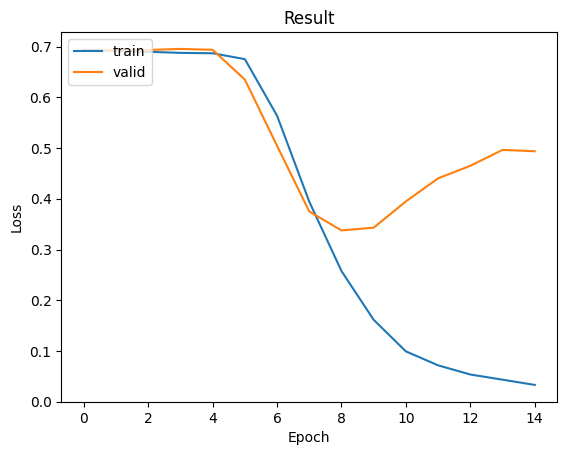

In [11]:
epochs = 15                              # 訓練次數
early_stopping = 7                       # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break

    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

In [12]:
model = TimeSeriesModel(embedding_dim = 300, hidden_size= 128, model_type = 'GRU').to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

TimeSeriesModel(
  (embedding): Embedding(29065, 300, padding_idx=0)
  (series_model): GRU(300, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [13]:
label_decoding = {0:'negative', 1:'positive'}
text = x_valid[0].unsqueeze(0).to(device)

output = model(text)                                     
pred = (output.view(-1) > 0.5)
label = y_valid.tolist()[0]                                # 取得Label

print('Pred Label:',label_decoding[int(pred)])             # 顯示文字 
print('Real Label:',label_decoding[label])                 # 顯示文字 
print('Reivew:\n', " ".join(token_vocab.lookup_tokens(x_valid[0].tolist())))

Pred Label: negative
Real Label: negative
Reivew:
 first off i want to say that i lean liberal on the political scale and i found the movie offensive . i managed to watch the whole <unk> disgrace of a film . this movie brings a low to original ideas . yes it was original thus my 2 stars instead of 1 . are our film writers that uncreative that they can only come up with this ? ? acting was horrible , and the characters were unlikeable for the most part . the lead lady in the story had no good qualities at all . they made her <unk> into some sort of a bad guy and i did not see that at all . maybe i missed something , i do not know . he was the most down to earth , relevant character in the movie . i did not shell out any money for this garbage . i almost wish peta would come to the rescue of this awful , offensive movie and form a protest . disgusting thats all i have to say anymore !
